# Tutorial: Loading Data from MSMD
In this tutorial we show how to load the data and annotations provided with
the Multimodal Audio Sheet Music (MSMD) dataset.

First we need to import a couple of python packages:

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from sheet_manager.midi_parser import notes_to_onsets, FPS
from sheet_manager.data_model.piece import Piece
from sheet_manager.alignments import align_score_to_performance

 
Music21 v.4 is the last version that will support Python 2.
Please start using Python 3 instead.

Set music21.environment.UserSettings()['warnings'] = 0
to disable this message.



Here we set the root path of the data set and select the piece we would like to load in this tutorial.

In [2]:
# path to MSMD data set
DATA_ROOT_MSMD = '/media/matthias/Data/msmd_aug/'

# select a piece you would like to view
piece_name = 'BachJS__BWV849__bwv849b'

## Loading the sheet image data
In the next couple of cells we load the sheet images along with their annotations.

In [3]:
# piece loading
piece = Piece(root=DATA_ROOT_MSMD, name=piece_name)
score = piece.load_score(piece.available_scores[0])

In [4]:
# get mungos
# (this is our annotation format containing for example system and notehead annotations)
mungos = score.load_mungos()
mdict = {m.objid: m for m in mungos}
mungos_per_page = score.load_mungos(by_page=True)

In [19]:
# load images
images = score.load_images()
print("Number of pages", len(images))

Number of pages 3


Lets visualize the sheet images.

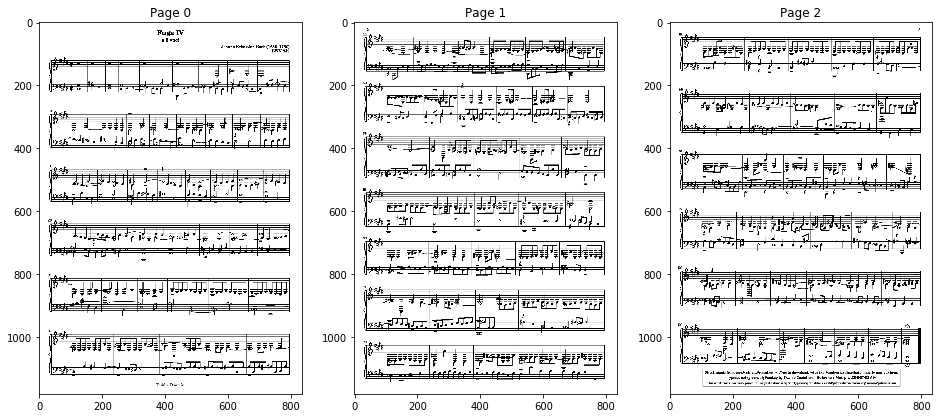

In [6]:
plt.figure("Sheet Images", figsize=(16, 8))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i], cmap="gray")
    plt.title("Page %d" % i)
plt.show()

Next we extract the staff system and note head annotations (only for the first page).

In [7]:
# get only systems
system_mungos = [c for c in mungos_per_page[0] if c.clsname == 'staff']
system_mungos = sorted(system_mungos, key=lambda m: m.top)

# get only noteheads
notehead_mungos = [c for c in mungos_per_page[0] if c.clsname == 'notehead-full']

... and plot it along with the sheet image.

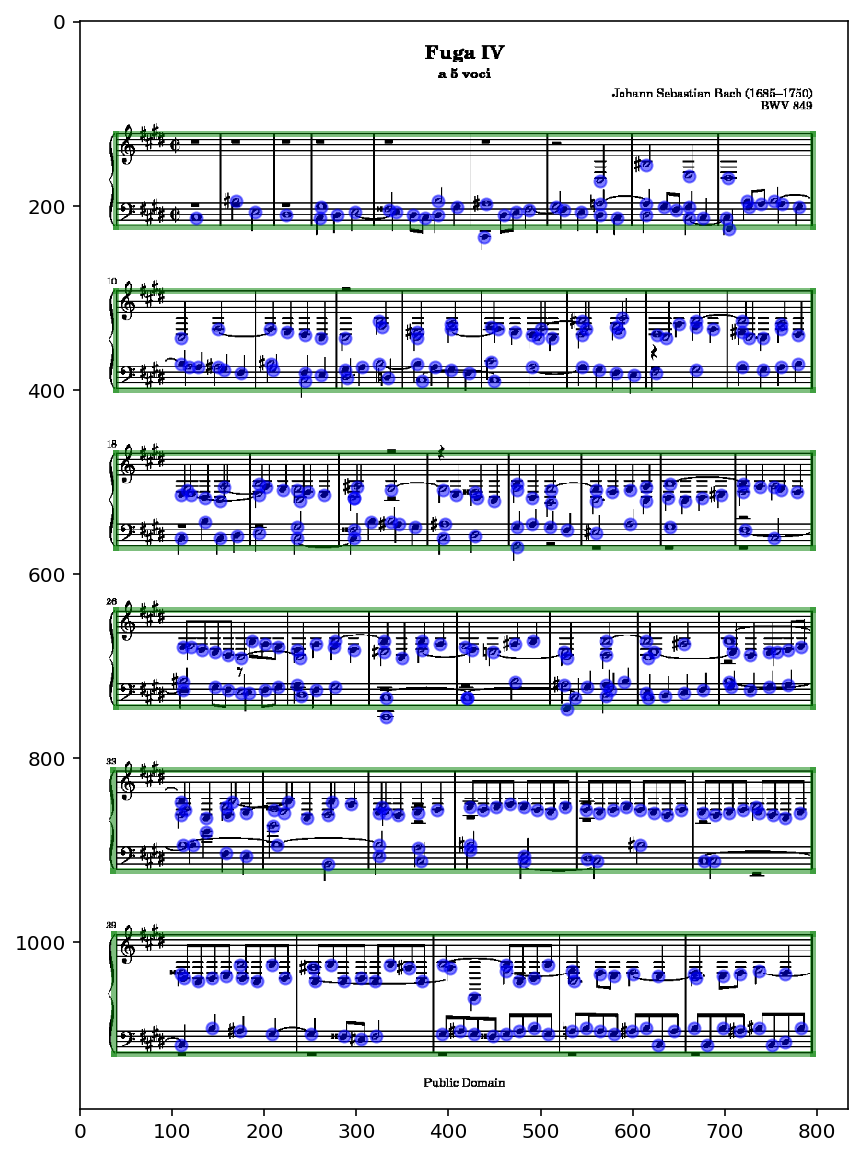

In [20]:
plt.figure("Page with Systems", figsize=(8, 10))
plt.imshow(images[0], cmap="gray")

# plot systems to sheet
for sys_mungo in system_mungos:
    t, l, b, r = sys_mungo.bounding_box
    plt.plot([l, r], [t, t], c='g', linewidth=3, alpha=0.5)
    plt.plot([l, r], [b, b], c='g', linewidth=3, alpha=0.5)
    plt.plot([l, l], [t, b], c='g', linewidth=3, alpha=0.5)
    plt.plot([r, r], [t, b], c='g', linewidth=3, alpha=0.5)

# plot noteheads to sheet
for n in notehead_mungos:
    plt.plot(n.middle[1], n.middle[0], "bo", alpha=0.5)
plt.show()

## Loading performance data
In the next coupl'e of cells we load the performance (audio) part of the piece.

In [9]:
# get the first one of the available performance identifiers
performance_key = piece.available_performances[0]
print(performance_key)

BachJS__BWV849__bwv849b_tempo-1000_ElectricPiano


In [10]:
# load the performance
performance = piece.load_performance(performance_key, require_audio=False)

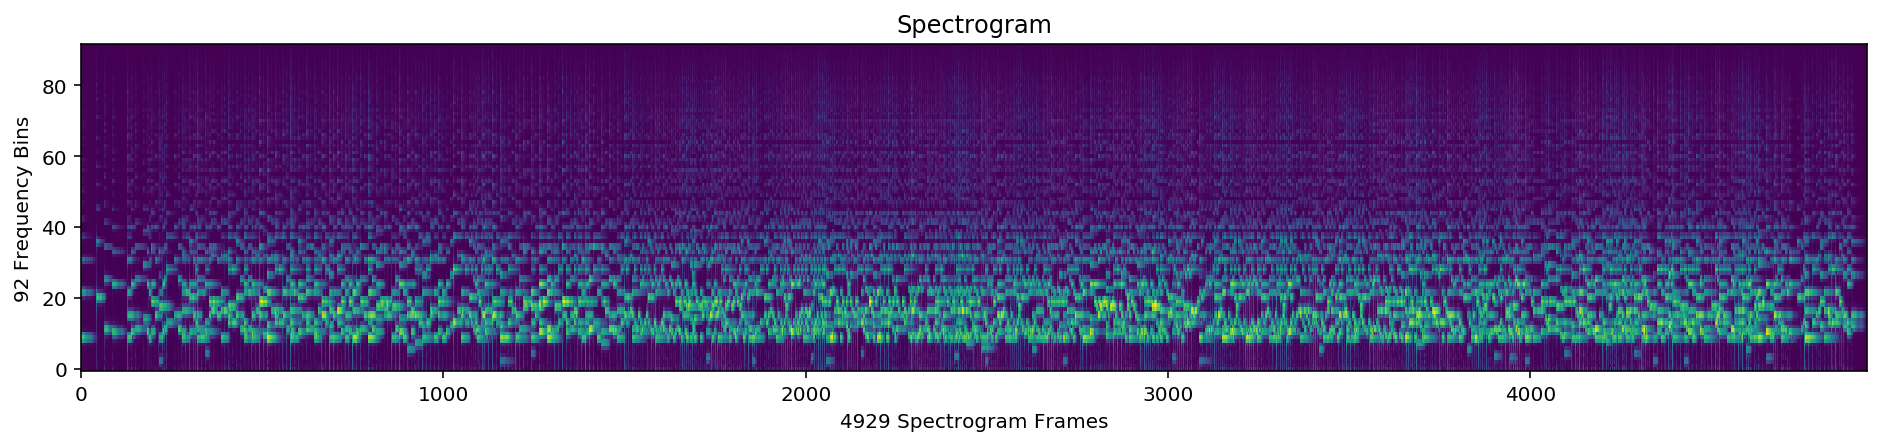

In [18]:
# load spectrogram
spectrogram = performance.load_spectrogram()

# show the spectrogram
plt.figure("Spectrogram", figsize=(16, 3))
plt.imshow(spectrogram, cmap="viridis", aspect="auto", origin="lower")
plt.title("Spectrogram")
plt.ylabel("%d Frequency Bins" % spectrogram.shape[0])
plt.xlabel("%d Spectrogram Frames" % spectrogram.shape[1])
plt.show()

## Aligning the two modalities
The last thing to do is to align the two modalities.

In [12]:
# running the alignment procedure
alignment = align_score_to_performance(score, performance)

# note events
note_events = performance.load_note_events()

In [13]:
# to make this easier for us we make it a dictionary
# and accessible by object id
mung_dict = {m.objid: m for m in mungos}

In [14]:
# get one entry in the alignment matrix
# (this is by id)
m_objid, e_idx = alignment[18]

In [15]:
# now we actually get the data
note_object = mung_dict[m_objid]
midi_event = note_events[e_idx]

In [16]:
# given the midi note event we compute the corresponding onset frame
dt = 1.0 / FPS
onset_frame = int(np.ceil(midi_event[0] / dt))

## Visualizing the Final Result

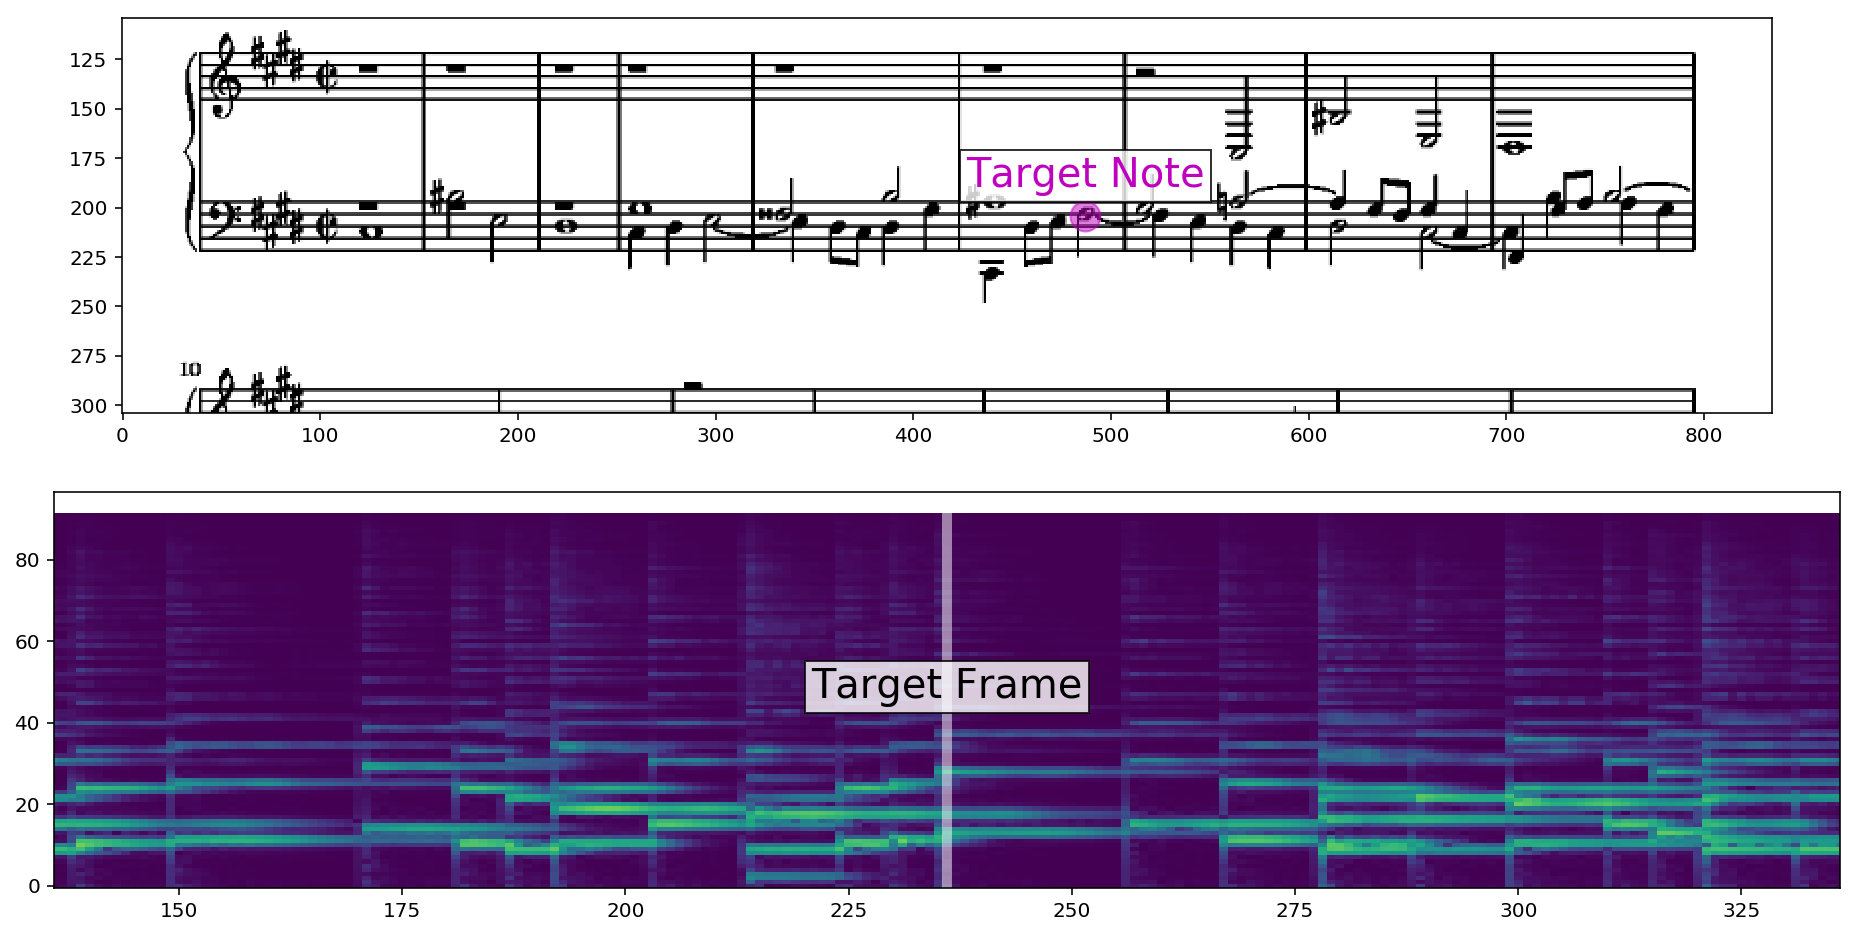

In [17]:
# show the spectrogram
plt.figure("Alignment", figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.imshow(images[0], cmap="gray")
plt.plot(note_object.middle[1], note_object.middle[0], 'mo', markersize=15, alpha=0.5)
plt.ylim([note_object.middle[0] + 100, note_object.middle[0] - 100])
plt.text(note_object.middle[1], note_object.middle[0] - 10, "Target Note",
         bbox={'facecolor':'w', 'alpha':0.8, 'pad':3},
         ha="center", va="bottom", color="m", fontsize=20)

plt.subplot(2, 1, 2)
plt.imshow(spectrogram, cmap="viridis", aspect="auto", origin="lower")
plt.plot([onset_frame, onset_frame], [0, spectrogram.shape[0]], 'w-', linewidth=5, alpha=0.5)
plt.xlim([onset_frame - 100, onset_frame + 100])
plt.text(onset_frame, spectrogram.shape[0] // 2, "Target Frame",
         bbox={'facecolor':'w', 'alpha':0.8, 'pad':3},
         ha="center", color="k", fontsize=20)

plt.show()